# importing libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# importing datasets

In [2]:
train=pd.read_csv('train.tsv',delimiter="\t")
test=pd.read_csv('test.tsv',delimiter='\t')

In [3]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
#from tqdm import tqdm

In [7]:
from tensorflow.keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [34]:
set_random_seed(123)
random.seed(123)
from nltk.corpus import stopwords # Import the stop word list
stopwords.words("english") 

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Function for cleaning the reviews, tokenize and lemmatize them.
This function will take each phrase iteratively and it will

    remove html content
    remove non-alphabetic characters
    tokenize the sentences
    lemmatize each word to its lemma
and then return the result in the list named reviews

In [35]:
def clean_sentences(df):
    reviews = []

    for sent in (df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
        
        stops = set(stopwords.words("english"))                  
    # 
        # 5. Remove stop words
        meaningful_words = [w for w in words if not w in stops]
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
        reviews.append(lemma_words)

    return(reviews)
    

In [36]:
train_sentences=clean_sentences(train)
test_sentences =clean_sentences(test)

## Collect the dependent values and convert to one-hot encoded output using to_categorical

In [37]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [38]:
X_train,X_val,Y_train,Y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

### Geting the no of unique words and max length of a review available in the list of cleaned reviews.

In [39]:
unique_words = set()
len_max = 0

for sent in (X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

13619
30


## actual tokenizer of keras and convert to sequences

In [40]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

In [41]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 30) (31212, 30) (66292, 30)


## Early stopping to prevent overfitting
Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset. In this tutorial, you will discover the Keras API for adding early stopping to overfit deep learning neural network models.

In [42]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

### #Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.


In [45]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
#model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 300)           4085700   
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 128)           219648    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 4,361,761
Trainable params: 4,361,761
Non-trainable params: 0
____________________________________________

In [46]:
history=model.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=6, batch_size=512, verbose=1, callbacks=callback)


Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 134s 1ms/sample - loss: 1.0636 - acc: 0.5721 - val_loss: 0.8822 - val_acc: 0.6389
Epoch 2/6
124848/124848 [==============================] - 144s 1ms/sample - loss: 0.8477 - acc: 0.6584 - val_loss: 0.8457 - val_acc: 0.6555
Epoch 3/6
124848/124848 [==============================] - 145s 1ms/sample - loss: 0.7880 - acc: 0.6782 - val_loss: 0.8484 - val_acc: 0.6536
Epoch 4/6
124848/124848 [==============================] - 147s 1ms/sample - loss: 0.7639 - acc: 0.6871 - val_loss: 0.8670 - val_acc: 0.6509


#### #This is done for learning purpose only. One can play around with different hyper parameters combinations
#and try increase the accuracy even more. For example, a different learning rate, an extra dense layer 
 before output layer, etc. Cross validation could be used to evaluate the model and grid search 
#further to find unique combination of parameters that give maximum accuracy. This model has a validation
#accuracy of around 66.5%

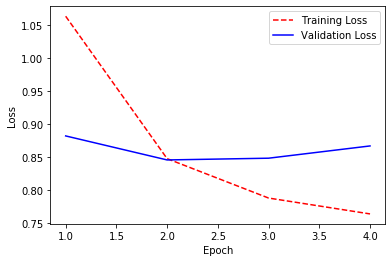

In [47]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [53]:
y_pred=model.predict_classes(X_test)

sub_file = pd.read_csv('sampleSubmission .csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission.csv',index=False)